# **Evaluation of custom loss function**  
  
  

## **Contents**
1. [Importing Libraries](evaluation_of_feature_enhancement.ipynb#1-importing-libraries)  
   
2. [Load Results](evaluation_of_feature_enhancement.ipynb#2-load-results)  
   
3. [RMSE and MAE](evaluation_of_feature_enhancement.ipynb#3-rmse-and-mae)  
   - 3.1 [RMSE and MAE Statistical Analysis](evaluation_of_feature_enhancement.ipynb#3.1-rmse-and-mae-statistical-analysis)  
  
4. [CG-EGA Summary Classification](evaluation_of_feature_enhancement.ipynb#4-cg-ega-summary-classification)
   - 4.1 [CG-EGA Summary Classification Statistical Analysis](evaluation_of_feature_enhancement.ipynb#4.1-cg-ega-summary-classification-statistical-analysis)  
  


## **1. Importing Libraries**

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from IPython.display import display

current_dir = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(current_dir, "../../../../../../"))

sys.path.append(os.path.join(PROJECT_ROOT, "shared_utilities"))
from metrics import *



## **2. Load Results**

In [4]:

"""jpformer base model using dual loss function"""

loss_directory = os.path.join(PROJECT_ROOT, "models", "jpformer","development_training_files", "loss_function")

dual_weighted_rmse_cgega_summary = pd.read_csv(os.path.join(loss_directory, "dual_weighted_rmse/overall_cg_ega.csv"))

dual_weighted_rmse_full_results = pd.read_csv(os.path.join(loss_directory, "dual_weighted_rmse/detailed_results_table.csv"))


"""higher dimensional model"""
dimension_directory = os.path.join(PROJECT_ROOT, "models/jpformer/development_training_files/architecture/dimension_and_n_heads")

high_dimension_cgega_summary = pd.read_csv(os.path.join(dimension_directory, "high_dim/overall_cg_ega.csv"))

high_dimension_full_results = pd.read_csv(os.path.join(dimension_directory, "high_dim/detailed_results_table.csv"))


"""lower dimensional model"""

low_dimension_cgega_summary = pd.read_csv(os.path.join(dimension_directory, "low_dim/overall_cg_ega.csv"))

low_dimension_full_results = pd.read_csv(os.path.join(dimension_directory, "low_dim/detailed_results_table.csv"))

## **3. RMSE and MAE**

In [5]:
# Define a simple RMSE function
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

base_dual_weighted_rmse = calculate_rmse(dual_weighted_rmse_full_results['true_glucose'], dual_weighted_rmse_full_results['predicted_glucose'])
high_dim_rmse = calculate_rmse(high_dimension_full_results['true_glucose'], high_dimension_full_results['predicted_glucose'])
low_dim_rmse = calculate_rmse(low_dimension_full_results['true_glucose'], low_dimension_full_results['predicted_glucose'])


def mae(predictions, targets):
    return np.mean(np.abs(predictions - targets))

base_dual_weighted_mae = mae(dual_weighted_rmse_full_results['true_glucose'], dual_weighted_rmse_full_results['predicted_glucose'])
high_dim__mae = mae(high_dimension_full_results['true_glucose'], high_dimension_full_results['predicted_glucose'])
low_dim_mae = mae(low_dimension_full_results['true_glucose'], low_dimension_full_results['predicted_glucose'])


In [6]:
rmse_mae_table = pd.DataFrame({
    "Model": ["Base Dual Weighted", "Low Dimension", "High Dimension"],
    "RMSE": [base_dual_weighted_rmse, low_dim_rmse, high_dim_rmse],
    "MAE": [base_dual_weighted_mae, low_dim_mae, high_dim__mae]
})

rmse_mae_table

,Model,RMSE,MAE
0,Base Dual Weighted,39.306174,27.148160
1,Low Dimension,40.349002,27.933618
2,High Dimension,38.364523,26.190472


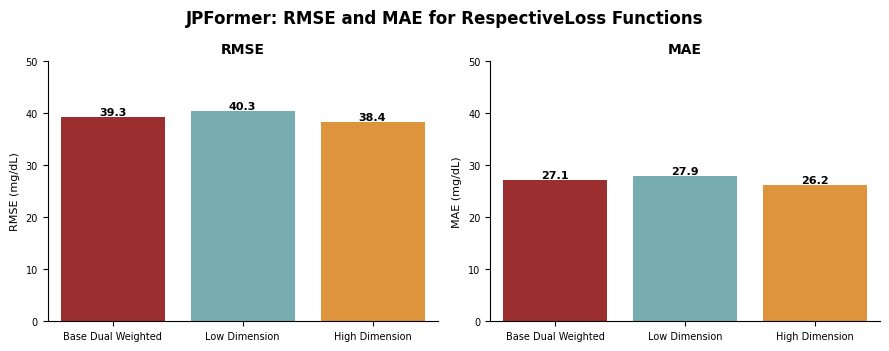

In [7]:
# Update model names in the DataFrame
rmse_mae_table['Model'] = ['Base Dual Weighted', 'Low Dimension', 'High Dimension']

# Plot comparison column chart for RMSE and MAE and display in a 2x1 grid
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Define custom colors for the models
model1_color = (173 / 255, 29 / 255, 30 / 255)  # Without Feature Enhancement
model2_color = (110 / 255, 180 / 255, 186 / 255)  # With Feature Enhancement
model3_color = (248 / 255, 151 / 255, 33 / 255)  # With Feature Enhancement
palette = [model1_color, model2_color, model3_color]

# Plot RMSE
sns.barplot(x='Model', y='RMSE', data=rmse_mae_table, ax=axs[0], hue='Model', palette=palette, legend=False)
axs[0].set_title('RMSE', fontsize=10, fontweight='bold')
axs[0].set_ylabel('RMSE (mg/dL)', fontsize=8)
axs[0].set_xlabel('')  # Remove x-axis label

# Plot MAE
sns.barplot(x='Model', y='MAE', data=rmse_mae_table, ax=axs[1], hue='Model', palette=palette, legend=False)
axs[1].set_title('MAE', fontsize=10, fontweight='bold')
axs[1].set_ylabel('MAE (mg/dL)', fontsize=8)
axs[1].set_xlabel('')  # Remove x-axis label

# Set y-axis limits and add data labels
for ax in axs:
    ax.set_ylim(0, 50)  # Adjusted to better fit the data range
    # Make tick labels smaller
    ax.tick_params(axis='both', labelsize=7)
    # Add data labels
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    # Remove top and right borders
    sns.despine(ax=ax)

# Add a suptitle
plt.suptitle('JPFormer: RMSE and MAE for RespectiveLoss Functions', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make room for the title
plt.subplots_adjust(bottom=0.2)  # Adjust to make room for the title
plt.show()


### **3.1 RMSE and MAE Statistical Analysis**

In [8]:
def return_ttests(model1, model2, glycemic_region, model1_name, model2_name):
    print(f"\nRunning t-test for {model1_name} vs {model2_name} ({glycemic_region.capitalize()}glycaemic Range Performance):\n")

    # Copy data to avoid modifying the originals
    df1 = model1.copy()
    df2 = model2.copy()

    # Filter based on glycemic region
    glycemic_region = glycemic_region.lower()
    if glycemic_region == 'hypo':
        df1 = df1[df1['glycemic_region'] == 'hypo']
        df2 = df2[df2['glycemic_region'] == 'hypo']
    elif glycemic_region == 'hyper':
        df1 = df1[df1['glycemic_region'] == 'hyper']
        df2 = df2[df2['glycemic_region'] == 'hyper']
    elif glycemic_region == 'eu':
        df1 = df1[df1['glycemic_region'] == 'eu']
        df2 = df2[df2['glycemic_region'] == 'eu']
    else:
        pass  # Use all data if 'overall' or invalid

    # Calculate errors
    df1['absolute_error'] = np.abs(df1['true_glucose'] - df1['predicted_glucose'])
    df2['absolute_error'] = np.abs(df2['true_glucose'] - df2['predicted_glucose'])

    df1['squared_error'] = df1['absolute_error'] ** 2
    df2['squared_error'] = df2['absolute_error'] ** 2

    df1mae = df1['absolute_error'].mean()
    df1mse = df1['squared_error'].mean()

    df2mae = df2['absolute_error'].mean()
    df2mse = df2['squared_error'].mean()

    # Use Welch’s t-test (unpaired, unequal variance)
    tt_mae, p_mae = stats.ttest_ind(df1['absolute_error'], df2['absolute_error'], equal_var=False)
    tt_mse, p_mse = stats.ttest_ind(df1['squared_error'], df2['squared_error'], equal_var=False)

    # Format results
    results = pd.DataFrame({
        "Metric": ["MAE", "MSE"],
        "t-statistic": [tt_mae, tt_mse],
        "p-value": [p_mae, p_mse],
        "Significance (p < 0.05)": [p_mae < 0.05, p_mse < 0.05]
    })
    print(f"{model1_name} MAE: {df1mae:.2f}"
          f"\n{model2_name} MAE: {df2mae:.2f}"
          f"\n\n{model1_name} MSE: {df1mse:.2f}"
          f"\n{model2_name} MSE: {df2mse:.2f}")
    
    display(results)

    print(f"\n{'_ _'*30}\n")
    return results

In [9]:
# These must all be DataFrames, not scalar metrics
base_dual_weighted_low_dim_ttest = return_ttests(dual_weighted_rmse_full_results, low_dimension_full_results, 'overall', 'Base JPformer', 'Low Dimension JPformer')
base_dual_weighted_high_dim_ttest = return_ttests(dual_weighted_rmse_full_results, high_dimension_full_results, 'overall', 'Base JPformer', 'High Dimension JPformer')
low_dim__high_dim_ttest = return_ttests(low_dimension_full_results, high_dimension_full_results, 'overall', 'Low Dimension JPformer', 'High Dimension JPformer')


Running t-test for Base JPformer vs Low Dimension JPformer (Overallglycaemic Range Performance):

Base JPformer MAE: 27.15
Low Dimension JPformer MAE: 27.93

Base JPformer MSE: 1544.98
Low Dimension JPformer MSE: 1628.04


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,-35.622291,6.716111e-278,True
1,MSE,-28.788670,3.049722e-182,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


Running t-test for Base JPformer vs High Dimension JPformer (Overallglycaemic Range Performance):

Base JPformer MAE: 27.15
High Dimension JPformer MAE: 26.19

Base JPformer MSE: 1544.98
High Dimension JPformer MSE: 1471.84


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,44.268116,0.000000e+00,True
1,MSE,26.273105,3.961716e-152,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


Running t-test for Low Dimension JPformer vs High Dimension JPformer (Overallglycaemic Range Performance):

Low Dimension JPformer MAE: 27.93
High Dimension JPformer MAE: 26.19

Low Dimension JPformer MSE: 1628.04
High Dimension JPformer MSE: 1471.84


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,79.587481,0.0,True
1,MSE,54.918077,0.0,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _



In [10]:
# These must all be DataFrames, not scalar metrics
base_dual_weighted_low_dim_ttest = return_ttests(dual_weighted_rmse_full_results, low_dimension_full_results, 'hypo', 'Base JPformer', 'Low Dimension JPformer')
base_dual_weighted_high_dim_ttest = return_ttests(dual_weighted_rmse_full_results, high_dimension_full_results, 'hypo', 'Base JPformer', 'High Dimension JPformer')
low_dim__high_dim_ttest = return_ttests(low_dimension_full_results, high_dimension_full_results, 'hypo', 'Low Dimension JPformer', 'High Dimension JPformer')


Running t-test for Base JPformer vs Low Dimension JPformer (Hypoglycaemic Range Performance):

Base JPformer MAE: 17.66
Low Dimension JPformer MAE: 17.33

Base JPformer MSE: 1037.91
Low Dimension JPformer MSE: 954.38


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,3.169137,1.529109e-03,True
1,MSE,6.142472,8.136902e-10,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


Running t-test for Base JPformer vs High Dimension JPformer (Hypoglycaemic Range Performance):

Base JPformer MAE: 17.66
High Dimension JPformer MAE: 18.44

Base JPformer MSE: 1037.91
High Dimension JPformer MSE: 1087.03


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,-7.211270,5.558834e-13,True
1,MSE,-3.534946,4.079314e-04,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


Running t-test for Low Dimension JPformer vs High Dimension JPformer (Hypoglycaemic Range Performance):

Low Dimension JPformer MAE: 17.33
High Dimension JPformer MAE: 18.44

Low Dimension JPformer MSE: 954.38
High Dimension JPformer MSE: 1087.03


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,-10.539388,5.758919e-26,True
1,MSE,-9.812406,1.005135e-22,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _



In [11]:
# These must all be DataFrames, not scalar metrics
base_dual_weighted_low_dim_ttest = return_ttests(dual_weighted_rmse_full_results, low_dimension_full_results, 'eu', 'Base JPformer', 'Low Dimension JPformer')
base_dual_weighted_high_dim_ttest = return_ttests(dual_weighted_rmse_full_results, high_dimension_full_results, 'eu', 'Base JPformer', 'High Dimension JPformer')
low_dim__high_dim_ttest = return_ttests(low_dimension_full_results, high_dimension_full_results, 'eu', 'Low Dimension JPformer', 'High Dimension JPformer')


Running t-test for Base JPformer vs Low Dimension JPformer (Euglycaemic Range Performance):

Base JPformer MAE: 25.25
Low Dimension JPformer MAE: 25.32

Base JPformer MSE: 1154.71
Low Dimension JPformer MSE: 1151.12


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,-3.103111,0.001915,True
1,MSE,1.803870,0.071252,False



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


Running t-test for Base JPformer vs High Dimension JPformer (Euglycaemic Range Performance):

Base JPformer MAE: 25.25
High Dimension JPformer MAE: 23.85

Base JPformer MSE: 1154.71
High Dimension JPformer MSE: 1073.64


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,65.190062,0.0,True
1,MSE,41.131807,0.0,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


Running t-test for Low Dimension JPformer vs High Dimension JPformer (Euglycaemic Range Performance):

Low Dimension JPformer MAE: 25.32
High Dimension JPformer MAE: 23.85

Low Dimension JPformer MSE: 1151.12
High Dimension JPformer MSE: 1073.64


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,68.535568,0.0,True
1,MSE,39.522140,0.0,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _



In [12]:
# These must all be DataFrames, not scalar metrics
base_dual_weighted_low_dim_ttest = return_ttests(dual_weighted_rmse_full_results, low_dimension_full_results, 'hyper', 'Base JPformer', 'Low Dimension JPformer')
base_dual_weighted_high_dim_ttest = return_ttests(dual_weighted_rmse_full_results, high_dimension_full_results, 'hyper', 'Base JPformer', 'High Dimension JPformer')
low_dim__high_dim_ttest = return_ttests(low_dimension_full_results, high_dimension_full_results, 'hyper', 'Low Dimension JPformer', 'High Dimension JPformer')


Running t-test for Base JPformer vs Low Dimension JPformer (Hyperglycaemic Range Performance):

Base JPformer MAE: 32.17
Low Dimension JPformer MAE: 34.57

Base JPformer MSE: 2408.47
Low Dimension JPformer MSE: 2689.59


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,-46.329217,0.000000e+00,True
1,MSE,-35.672470,1.277287e-278,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


Running t-test for Base JPformer vs High Dimension JPformer (Hyperglycaemic Range Performance):

Base JPformer MAE: 32.17
High Dimension JPformer MAE: 31.92

Base JPformer MSE: 2408.47
High Dimension JPformer MSE: 2337.42


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,4.873702,1.095342e-06,True
1,MSE,9.404180,5.248628e-21,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


Running t-test for Low Dimension JPformer vs High Dimension JPformer (Hyperglycaemic Range Performance):

Low Dimension JPformer MAE: 34.57
High Dimension JPformer MAE: 31.92

Low Dimension JPformer MSE: 2689.59
High Dimension JPformer MSE: 2337.42


,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,51.550750,0.0,True
1,MSE,45.343508,0.0,True



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _



## **4. CG-EGA Summary Classifications**

In [13]:
dual_weighted_rmse_full_results['AP'] = np.where(dual_weighted_rmse_full_results['CG_EGA_Class'] == 'AP', 1, 0)
dual_weighted_rmse_full_results['BE'] = np.where(dual_weighted_rmse_full_results['CG_EGA_Class'] == 'BE', 1, 0)
dual_weighted_rmse_full_results['EP'] = np.where(dual_weighted_rmse_full_results['CG_EGA_Class'] == 'EP', 1, 0)

low_dimension_full_results['AP'] = np.where(low_dimension_full_results['CG_EGA_Class'] == 'AP', 1, 0)
low_dimension_full_results['BE'] = np.where(low_dimension_full_results['CG_EGA_Class'] == 'BE', 1, 0)
low_dimension_full_results['EP'] = np.where(low_dimension_full_results['CG_EGA_Class'] == 'EP', 1, 0)

high_dimension_full_results['AP'] = np.where(high_dimension_full_results['CG_EGA_Class'] == 'AP', 1, 0)
high_dimension_full_results['BE'] = np.where(high_dimension_full_results['CG_EGA_Class'] == 'BE', 1, 0)
high_dimension_full_results['EP'] = np.where(high_dimension_full_results['CG_EGA_Class'] == 'EP', 1, 0)

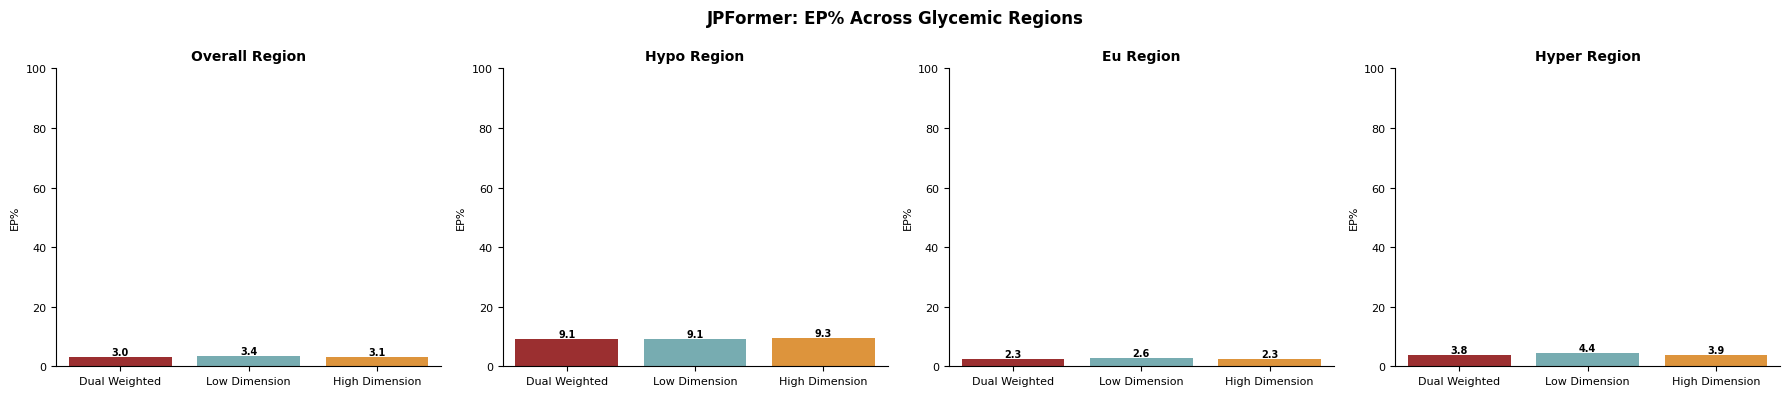

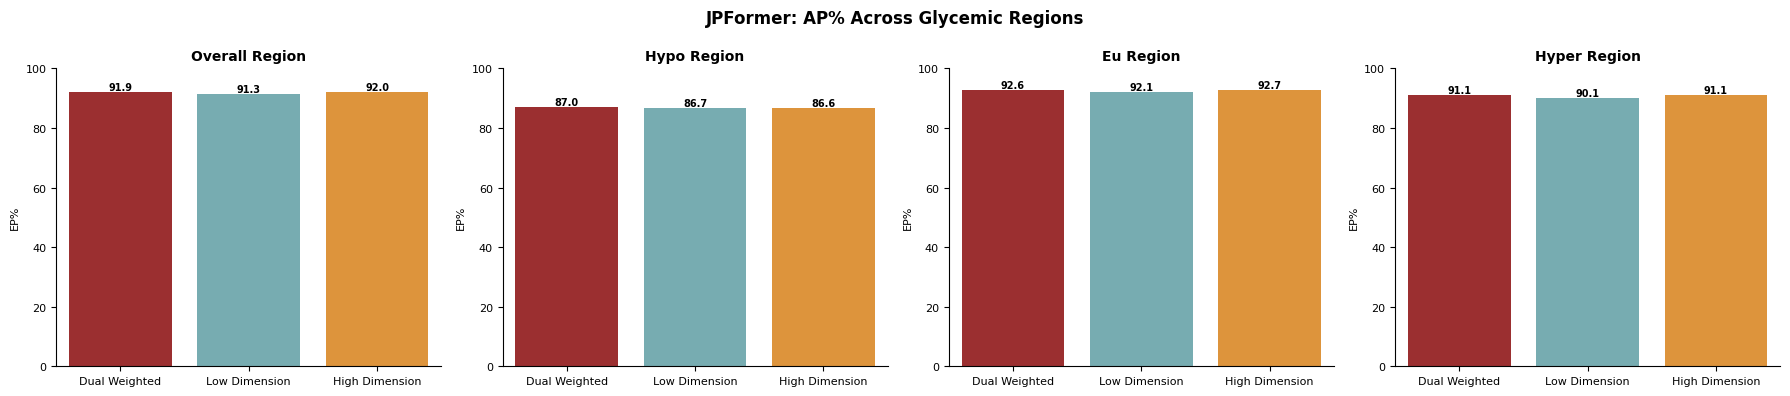

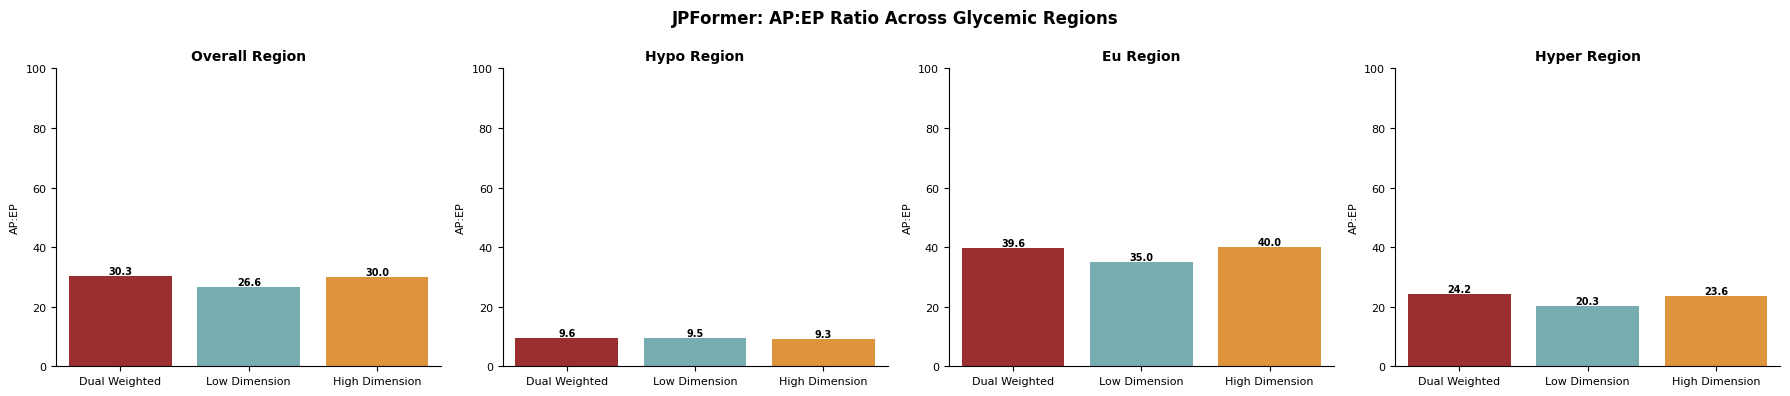

In [27]:
# Define custom colors for the models
model1_color = (173 / 255, 29 / 255, 30 / 255)  # Base Model
model2_color = (110 / 255, 180 / 255, 186 / 255)  # Single Weighted Model
model3_color = (248 / 255, 151 / 255, 33 / 255)  # Dual Weighted Model
palette = [model1_color, model2_color, model3_color]

# Create summary tables for overall, hypo, eu, and hyper glycaemic regions
regions = ['overall', 'hypo', 'eu', 'hyper']
summary_tables = {}

for region in regions:
    # Initialize empty DataFrame with specific dtypes to avoid warning
    summary_df = pd.DataFrame({
        'Model': pd.Series(dtype='object'),
        'AP': pd.Series(dtype='int64'), 
        'BE': pd.Series(dtype='int64'), 
        'EP': pd.Series(dtype='int64'), 
        'Count': pd.Series(dtype='int64'),
        'AP_pct': pd.Series(dtype='float64'), 
        'BE_pct': pd.Series(dtype='float64'), 
        'EP_pct': pd.Series(dtype='float64')
    })
    
    # Process each model
    for model, df in zip(
        ['Dual Weighted', 'Low Dimension', 'High Dimension'], 
        [dual_weighted_rmse_full_results, low_dimension_full_results, high_dimension_full_results]
    ):
        # Filter for region if not overall
        if region != 'overall':
            region_df = df[df['glycemic_region'] == region]
        else:
            region_df = df
            
        # Calculate counts
        ap_count = region_df['AP'].sum()
        be_count = region_df['BE'].sum()
        ep_count = region_df['EP'].sum()
        total_count = len(region_df)
        
        # Create a new row as a dictionary and append it to the DataFrame
        new_row = {
            'Model': model, 
            'AP': ap_count, 
            'BE': be_count, 
            'EP': ep_count, 
            'Count': total_count,
            'AP:EP': ap_count / ep_count if ep_count != 0 else np.nan,
            'AP_pct': ap_count / total_count * 100, 
            'BE_pct': be_count / total_count * 100, 
            'EP_pct': ep_count / total_count * 100
        }
        summary_df = pd.concat([summary_df, pd.DataFrame([new_row])], ignore_index=True)
    
    # Store in dictionary
    summary_tables[region] = summary_df
# Create figure for visualizing EP percentages across regions
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

# Plot EP percentages for each region
for i, region in enumerate(regions):
    sns.barplot(
        x='Model', 
        y='EP_pct', 
        data=summary_tables[region], 
        ax=axs[i], 
        palette=palette,
        hue='Model',
        legend=False
    )
    axs[i].set_title(f'{region.capitalize()} Region', fontsize=10, fontweight='bold')
    axs[i].set_ylabel('EP%', fontsize=8)
    axs[i].set_xlabel('')  # Remove x-axis label
    axs[i].set_ylim(0, 100)  # Adjust y-axis limit for better visualization
    axs[i].tick_params(axis='both', labelsize=8)
    
    # Add data labels
    for p in axs[i].patches:
        axs[i].annotate(f"{p.get_height():.1f}", 
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Remove top and right borders
    sns.despine(ax=axs[i])

plt.suptitle('JPFormer: EP% Across Glycemic Regions',
             fontsize=12, fontweight='bold')
plt.subplots_adjust(top=0.85)  # Adjust to make room for the title
plt.tight_layout()
plt.show()

# Create figure for visualizing EP percentages across regions
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for i, region in enumerate(regions):
    sns.barplot(
        x='Model', 
        y='AP_pct', 
        data=summary_tables[region], 
        ax=axs[i], 
        palette=palette,
        hue='Model',
        legend=False
    )
    axs[i].set_title(f'{region.capitalize()} Region', fontsize=10, fontweight='bold')
    axs[i].set_ylabel('EP%', fontsize=8)
    axs[i].set_xlabel('')  # Remove x-axis label
    axs[i].set_ylim(0, 100)  # Adjust y-axis limit for better visualization
    axs[i].tick_params(axis='both', labelsize=8)
    
    # Add data labels
    for p in axs[i].patches:
        axs[i].annotate(f"{p.get_height():.1f}", 
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Remove top and right borders
    sns.despine(ax=axs[i])

plt.suptitle('JPFormer: AP% Across Glycemic Regions',
             fontsize=12, fontweight='bold')
plt.subplots_adjust(top=0.85)  # Adjust to make room for the title
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(18, 4))

# Plot AP:EP ratio for each region
for i, region in enumerate(regions):
    sns.barplot(
        x='Model', 
        y='AP:EP', 
        data=summary_tables[region], 
        ax=axs[i], 
        palette=palette,
        hue='Model',
        dodge=False
    )
    axs[i].set_title(f'{region.capitalize()} Region', fontsize=10, fontweight='bold')
    axs[i].set_ylabel('AP:EP', fontsize=8)
    axs[i].set_xlabel('')  # Remove x-axis label
    axs[i].set_ylim(0, 100)  # Adjust y-axis limit for better visualization
    axs[i].tick_params(axis='both', labelsize=8)
    
    # Add data labels
    for p in axs[i].patches:
        axs[i].annotate(f"{p.get_height():.1f}", 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Remove top and right borders
    sns.despine(ax=axs[i])

plt.suptitle('JPFormer: AP:EP Ratio Across Glycemic Regions',
             fontsize=12, fontweight='bold')
plt.subplots_adjust(top=0.85)  # Adjust to make room for the title
# Adjust layout to prevent overlap  

plt.tight_layout()
plt.show()

In [ ]:
def create_timepoint_ega_dataframe(df, region=None):
    # Initialize a dataframe to store results with proper data types
    result_df = pd.DataFrame(index=(np.arange(24)+1) * 5)  # timepoints (n+1) * 5
    result_df.index.name = 'timepoint'
    
    # Initialize columns for percentages, counts and total
    result_df['AP_percent'] = 0.0
    result_df['BP_percent'] = 0.0
    result_df['EP_percent'] = 0.0
    result_df['AP_count'] = 0
    result_df['BP_count'] = 0
    result_df['EP_count'] = 0
    result_df['Total_count'] = 0
    
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()

    if region == 'hypo':
        # Filter for hypoglycemic readings only
        df = df[df['glycemic_region'] == 'hypo']
    elif region == 'hyper':
        # Filter for hyperglycemic readings only
        df = df[df['glycemic_region'] == 'hyper']
    elif region == 'eu':
        # Filter for euglycemic readings only
        df = df[df['glycemic_region'] == 'eu']
    else:
        df = df  # Use all data

    # Process each timepoint
    for timepoint in range(24):
        # Filter data for this timepoint
        timepoint_data = df[df['timepoint'] == timepoint]
        
        if len(timepoint_data) > 0:
            # Count occurrences of each CG_EGA_Class
            class_counts = timepoint_data['CG_EGA_Class'].value_counts()
            total_points = len(timepoint_data)
            
            # Store total count for this timepoint
            result_df.loc[(timepoint + 1) * 5, 'Total_count'] = total_points
            
            # Calculate percentages and counts for AP, BP, and EP
            for class_prefix in ['A', 'B', 'E']:
                # Find all classes that start with this letter (AP, BP, EP)
                class_matches = [c for c in class_counts.index if c.startswith(class_prefix)]
                count = sum([class_counts[c] for c in class_matches if c in class_counts])
                
                # Store count
                result_df.loc[(timepoint + 1) * 5, f'{class_prefix}P_count'] = count
                
                # Store percentage
                result_df.loc[(timepoint + 1) * 5, f'{class_prefix}P_percent'] = float((count / total_points) * 100)
    
    return result_df

In [16]:
def return_ph_chart(model1, model2, model3, glycemic_region):
    # Process data for each model using the create_timepoint_ega_dataframe function
    model1_timepoint_table = create_timepoint_ega_dataframe(model1, glycemic_region)
    model2_timepoint_table = create_timepoint_ega_dataframe(model2, glycemic_region)
    model3_timepoint_table = create_timepoint_ega_dataframe(model3, glycemic_region)

    # Plot the Erroneous Prediction % for both models
    plt.figure(figsize=(9, 4))

    # Define custom colors for the models
    model1_color = (173 / 255, 29 / 255, 30 / 255)  # Without Feature Enhancement
    model2_color = (110 / 255, 180 / 255, 186 / 255)  # With Feature Enhancement
    model3_color = (248 / 255, 151 / 255, 33 / 255)  # With Feature Enhancement


    plt.plot(model1_timepoint_table.index, model1_timepoint_table['EP_percent'], 
             label='Base Dual Weighted RMSE', marker='o', linestyle='-', markersize=4, 
             color=model1_color)
    plt.plot(model2_timepoint_table.index, model2_timepoint_table['EP_percent'], 
             label='Lower Dimension', marker='o', linestyle='-', markersize=4, 
             color=model2_color)
    plt.plot(model3_timepoint_table.index, model3_timepoint_table['EP_percent'],
             label='Higher Dimension', marker='o', linestyle='-', markersize=4,
             color=model3_color)

    # Add titles and labels
    plt.suptitle('JPFormer: With vs Without Feature Enhancement', fontsize=12, fontweight='bold')
    plt.title(f'Erroneous Prediction % in the {glycemic_region.capitalize()} Range by Prediction Horizon', 
              fontsize=10, fontweight='bold', ha='center')
    plt.xlabel('Prediction Horizon (mins)', fontsize=8, fontweight='bold', labelpad=5, ha='center')
    plt.ylabel('Erroneous Prediction %', fontsize=10, fontweight='bold', labelpad=5)
    plt.xticks(range(0, 121, 30), fontsize=9)
    plt.yticks(fontsize=9)

    # Format legend
    legend = plt.legend(title='Model', fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.2), 
                        ncol=2, frameon=False)
    legend.get_title().set_fontweight('bold')
    legend.get_title().set_fontsize(8)

    # Add grid and styling
    plt.grid(axis='y', linestyle='-', alpha=0.6)
    plt.ylim(0, 40)  # Adjust y-limit based on your data
    sns.despine()  # Remove top and right borders
    plt.tight_layout()
    plt.show()


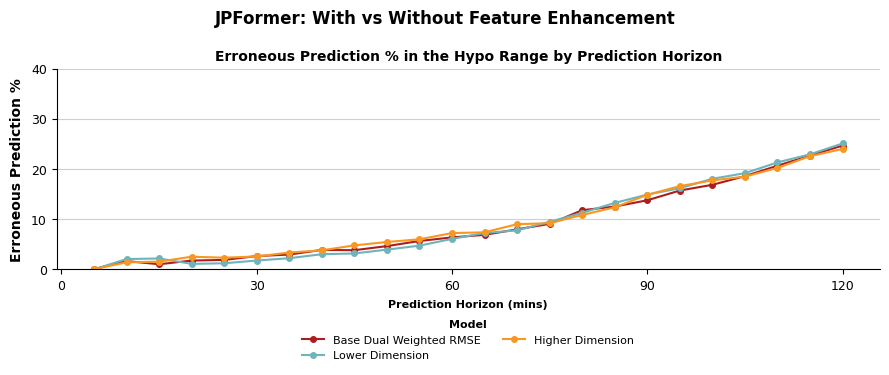

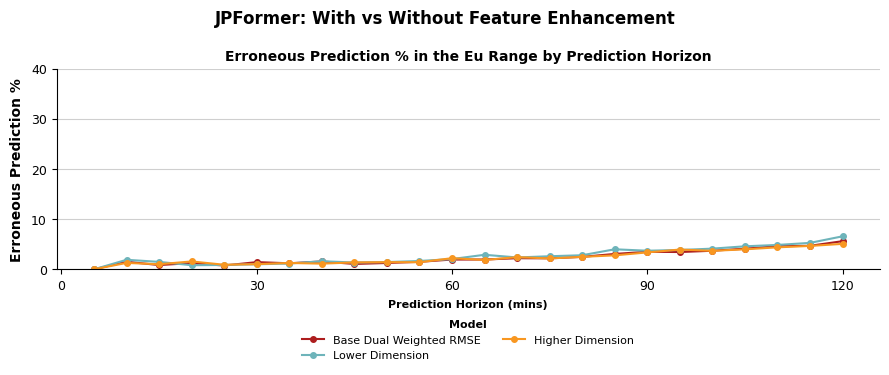

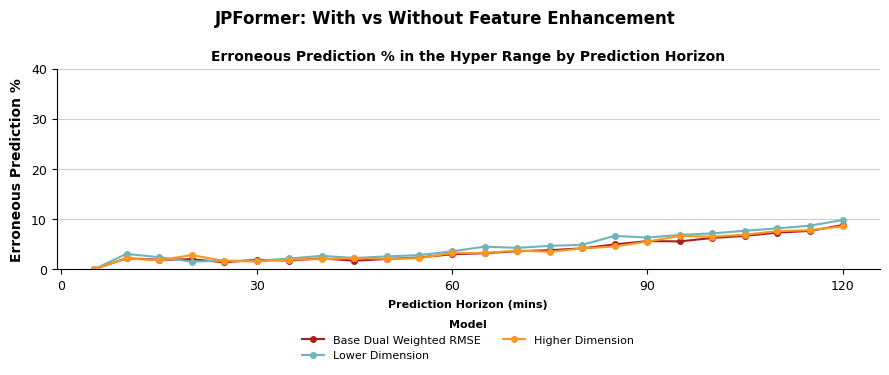

In [17]:
# Call the function with the appropriate arguments
return_ph_chart(model1=dual_weighted_rmse_full_results, model2=low_dimension_full_results,model3=high_dimension_full_results, glycemic_region='hypo')
return_ph_chart(model1=dual_weighted_rmse_full_results, model2=low_dimension_full_results,model3=high_dimension_full_results, glycemic_region='eu')
return_ph_chart(model1=dual_weighted_rmse_full_results, model2=low_dimension_full_results,model3=high_dimension_full_results, glycemic_region='hyper')

In [18]:
def return_timepoint_summary(model1, model1_name, model2, model2_name, model3, model3_name, glycemic_region):
    timepoints = [30, 60, 90, 120]

    # Create a dictionary to store DataFrames for each timepoint
    timepoint_dfs = {}

    # For each timepoint, create a DataFrame with rows from all three models
    for t in timepoints:
        # Create an empty DataFrame
        timepoint_df = pd.DataFrame(columns=['Model', 'AP_percent', 'BP_percent', 'EP_percent', 
                                             'AP_count', 'BP_count', 'EP_count', 'Total_count'])
        
        # Process data for each model using the create_timepoint_ega_dataframe function
        model1_timepoint_table = create_timepoint_ega_dataframe(model1, glycemic_region)
        model2_timepoint_table = create_timepoint_ega_dataframe(model2, glycemic_region)
        model3_timepoint_table = create_timepoint_ega_dataframe(model3, glycemic_region)

        # Get data from all models for this timepoint
        model1_data = model1_timepoint_table.loc[t].copy()
        model2_data = model2_timepoint_table.loc[t].copy()
        model3_data = model3_timepoint_table.loc[t].copy()
        
        # Create rows with model identifiers
        model1_row = pd.DataFrame({
            'Model': [model1_name],
            'AP_percent': [model1_data['AP_percent']],
            'BP_percent': [model1_data['BP_percent']],
            'EP_percent': [model1_data['EP_percent']],
            'AP_count': [model1_data['AP_count']],
            'BP_count': [model1_data['BP_count']],
            'EP_count': [model1_data['EP_count']],
            'Total_count': [model1_data['Total_count']]
        })
        
        model2_row = pd.DataFrame({
            'Model': [model2_name],
            'AP_percent': [model2_data['AP_percent']],
            'BP_percent': [model2_data['BP_percent']],
            'EP_percent': [model2_data['EP_percent']],
            'AP_count': [model2_data['AP_count']],
            'BP_count': [model2_data['BP_count']],
            'EP_count': [model2_data['EP_count']],
            'Total_count': [model2_data['Total_count']]
        })
        
        model3_row = pd.DataFrame({
            'Model': [model3_name],
            'AP_percent': [model3_data['AP_percent']],
            'BP_percent': [model3_data['BP_percent']],
            'EP_percent': [model3_data['EP_percent']],
            'AP_count': [model3_data['AP_count']],
            'BP_count': [model3_data['BP_count']],
            'EP_count': [model3_data['EP_count']],
            'Total_count': [model3_data['Total_count']]
        })
        
        # Combine the three rows
        timepoint_df = pd.concat([model1_row, model2_row, model3_row])
        
        # Store in dictionary
        timepoint_dfs[t] = timepoint_df

    # Create a figure to visualize EP percentages across timepoints
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs = axs.flatten()

    # Define custom colors for the models
    model1_color = (173 / 255, 29 / 255, 30 / 255)  # Base Model
    model2_color = (110 / 255, 180 / 255, 186 / 255)  # Single Weighted Model
    model3_color = (248 / 255, 151 / 255, 33 / 255)  # Dual Weighted Model
    palette = [model1_color, model2_color, model3_color]

    # Plot bar charts for each timepoint
    for i, t in enumerate(timepoints):
        sns.barplot(
            x='Model', 
            y='EP_percent', 
            data=timepoint_dfs[t], 
            ax=axs[i], 
            palette=palette,
            hue='Model',
            dodge=False
        )
        axs[i].set_title(f'Prediction Horizon: {t} mins', fontsize=10, fontweight='bold')
        axs[i].set_ylabel('Erroneous Prediction %', fontsize=8)
        axs[i].set_xlabel('')
        axs[i].set_ylim(0, 100)  # Set consistent y-axis limits
        
        # Add data labels
        for p in axs[i].patches:
            axs[i].annotate(f"{p.get_height():.1f}%", 
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # Set x-tick labels font size to 8
        axs[i].tick_params(axis='x', labelsize=8)
        
        # Remove top and right borders
        sns.despine(ax=axs[i])
    glycemic_region = glycemic_region.capitalize()
    # Add suptitle with more space
    plt.suptitle(f'JPFormer: CG-EGA EP% in {glycemic_region}glycaemic Range by Prediction Horizon', 
                 fontsize=12, fontweight='bold')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Increased space between title and plots
    plt.show()

    # Display the comparison tables
    for t in timepoints:
        print(f"\nPrediction Horizon: {t} minutes")
        display(timepoint_dfs[t])


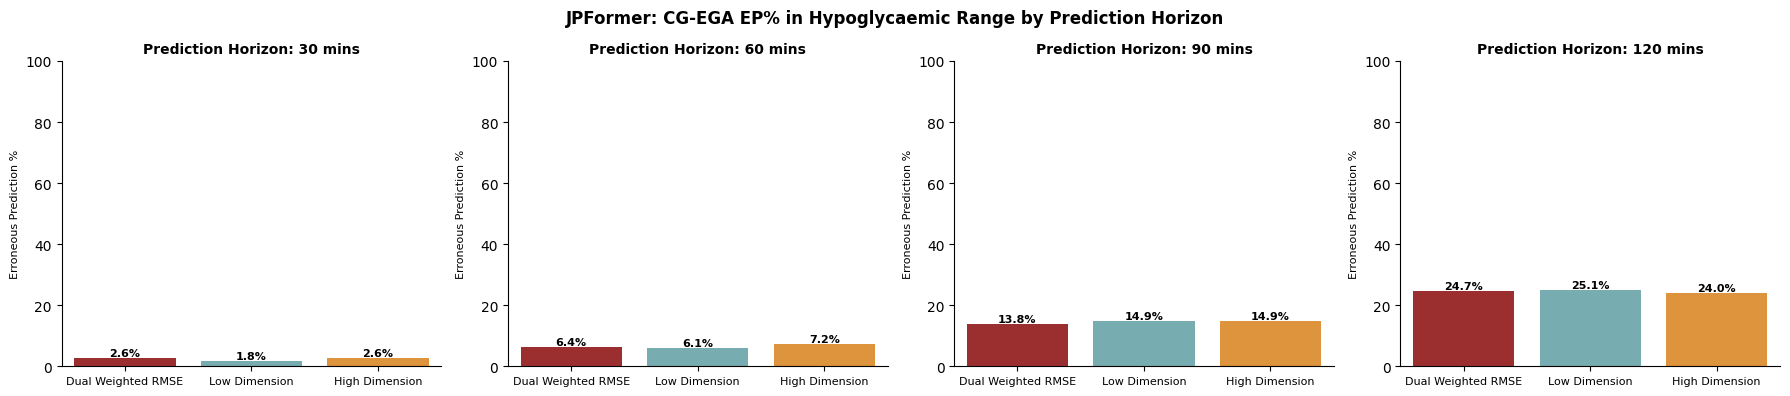


Prediction Horizon: 30 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,93.222630,4.132072,2.645298,4828.0,214.0,137.0,5179.0
0,Low Dimension,94.323228,3.919676,1.757096,4885.0,203.0,91.0,5179.0
0,High Dimension,92.411662,5.020274,2.568063,4786.0,260.0,133.0,5179.0



Prediction Horizon: 60 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,89.453646,4.169046,6.377308,4699.0,219.0,335.0,5253.0
0,Low Dimension,89.910527,4.016752,6.072720,4723.0,211.0,319.0,5253.0
0,High Dimension,87.740339,5.025700,7.233962,4609.0,264.0,380.0,5253.0



Prediction Horizon: 90 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,81.659640,4.561135,13.779226,4261.0,238.0,719.0,5218.0
0,Low Dimension,80.318130,4.771943,14.909927,4191.0,249.0,778.0,5218.0
0,High Dimension,80.203143,4.925259,14.871598,4185.0,257.0,776.0,5218.0



Prediction Horizon: 120 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,71.522538,3.791836,24.685626,3697.0,196.0,1276.0,5169.0
0,Low Dimension,69.800735,5.088025,25.111240,3608.0,263.0,1298.0,5169.0
0,High Dimension,71.251693,4.739795,24.008512,3683.0,245.0,1241.0,5169.0


In [19]:
return_timepoint_summary(dual_weighted_rmse_full_results, 'Dual Weighted RMSE', low_dimension_full_results, 'Low Dimension', high_dimension_full_results, 'High Dimension', 'hypo')

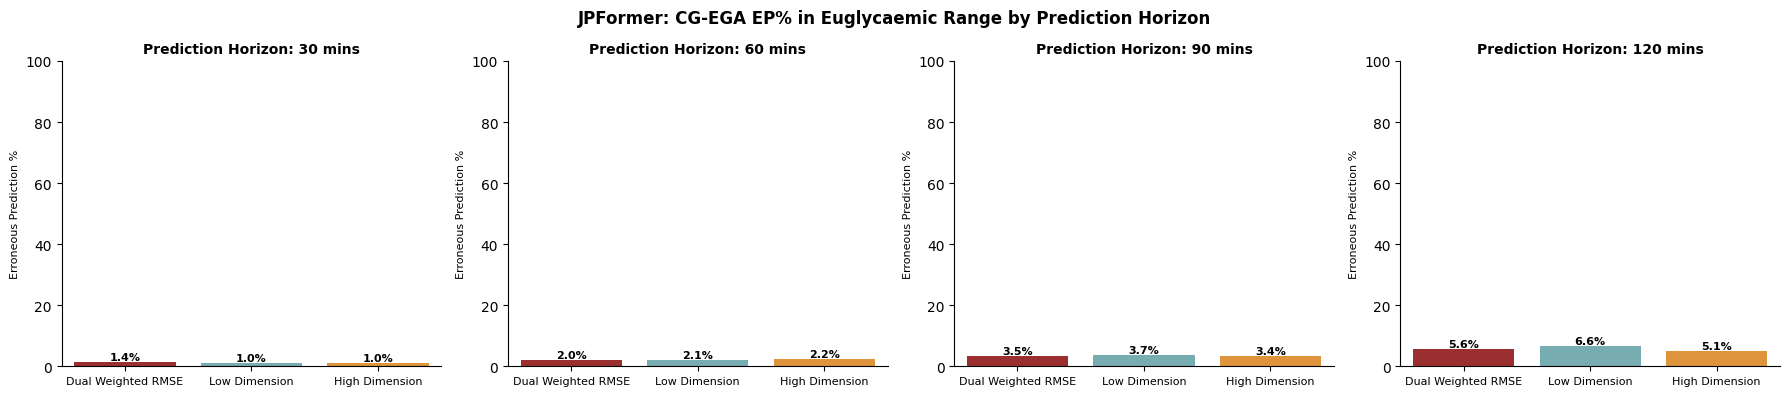


Prediction Horizon: 30 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,92.900225,5.658737,1.441038,85484.0,5207.0,1326.0,92017.0
0,Low Dimension,93.890259,5.101231,1.008509,86395.0,4694.0,928.0,92017.0
0,High Dimension,93.249074,5.721769,1.029158,85805.0,5265.0,947.0,92017.0



Prediction Horizon: 60 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,92.597267,5.446514,1.956219,85108.0,5006.0,1798.0,91912.0
0,Low Dimension,92.390547,5.556402,2.053051,84918.0,5107.0,1887.0,91912.0
0,High Dimension,91.730133,6.043825,2.226042,84311.0,5555.0,2046.0,91912.0



Prediction Horizon: 90 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,91.035906,5.460373,3.503721,83794.0,5026.0,3225.0,92045.0
0,Low Dimension,90.801239,5.484274,3.714487,83578.0,5048.0,3419.0,92045.0
0,High Dimension,91.176055,5.445163,3.378782,83923.0,5012.0,3110.0,92045.0



Prediction Horizon: 120 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,88.974217,5.406050,5.619733,82028.0,4984.0,5181.0,92193.0
0,Low Dimension,86.663846,6.746716,6.589437,79898.0,6220.0,6075.0,92193.0
0,High Dimension,89.465578,5.451607,5.082815,82481.0,5026.0,4686.0,92193.0


In [20]:
return_timepoint_summary(dual_weighted_rmse_full_results, 'Dual Weighted RMSE', low_dimension_full_results, 'Low Dimension', high_dimension_full_results, 'High Dimension', 'eu')

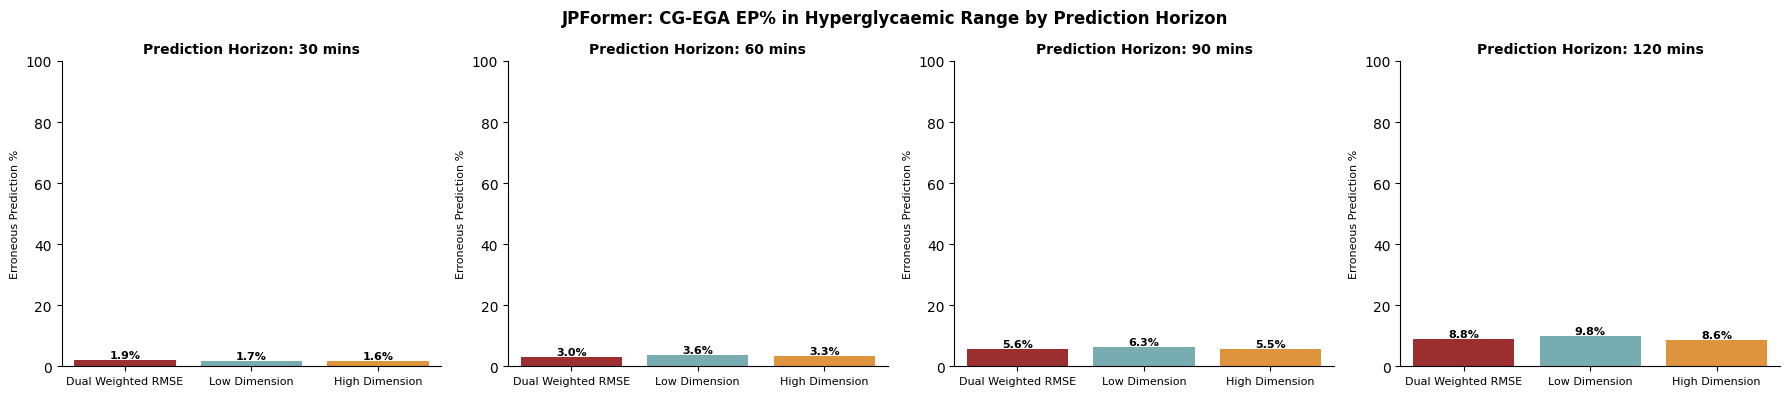


Prediction Horizon: 30 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,92.695749,5.404922,1.899329,41435.0,2416.0,849.0,44700.0
0,Low Dimension,92.926174,5.382550,1.691275,41538.0,2406.0,756.0,44700.0
0,High Dimension,92.881432,5.543624,1.574944,41518.0,2478.0,704.0,44700.0



Prediction Horizon: 60 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,91.343811,5.640384,3.015806,40859.0,2523.0,1349.0,44731.0
0,Low Dimension,90.512173,5.897476,3.590351,40487.0,2638.0,1606.0,44731.0
0,High Dimension,90.062820,6.675460,3.261720,40286.0,2986.0,1459.0,44731.0



Prediction Horizon: 90 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,88.120897,6.250980,5.628123,39331.0,2790.0,2512.0,44633.0
0,Low Dimension,87.869962,5.784957,6.345081,39219.0,2582.0,2832.0,44633.0
0,High Dimension,88.188112,6.277866,5.534022,39361.0,2802.0,2470.0,44633.0



Prediction Horizon: 120 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Dual Weighted RMSE,85.977006,5.193785,8.829209,38289.0,2313.0,3932.0,44534.0
0,Low Dimension,83.659676,6.509633,9.830691,37257.0,2899.0,4378.0,44534.0
0,High Dimension,85.727759,5.703507,8.568734,38178.0,2540.0,3816.0,44534.0


In [21]:
return_timepoint_summary(dual_weighted_rmse_full_results, 'Dual Weighted RMSE', low_dimension_full_results, 'Low Dimension', high_dimension_full_results, 'High Dimension', 'hyper')

### **4.1. Statistical Analysis**

In [22]:
from IPython.display import display

# Function to compute Cramér's V
def cramers_v(chi2, n, contingency_table):
    """Computes Cramér's V effect size from the chi-square test."""
    min_dim = min(np.shape(contingency_table)) - 1  # Min(row-1, col-1)
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

# Function to interpret Cramér's V effect size
def interpret_cramers_v(v_value):
    """Provides qualitative interpretation of Cramér's V."""
    if pd.isna(v_value):  
        return "Not Enough Data"
    elif v_value < 0.1:
        return "Negligible Effect"
    elif v_value < 0.3:
        return "Small Effect"
    elif v_value < 0.5:
        return "Medium Effect"
    else:
        return "Large Effect"

# Chi-square analysis function
def return_chi_square_analysis(model1, model2, glycemic_region, model1_name, model2_name):
    glycemic_region = glycemic_region.lower()
    data_dist_chi_square_results = []

    print(f"\n Running Chi-Square test for {model1_name} vs {model2_name} ({glycemic_region.capitalize()}glycaemic Range Performance):\n")

    # Copy data to avoid modifying the originals
    df1 = model1.copy()
    df2 = model2.copy()

    # Filter based on glycemic region
    if glycemic_region == 'hypo':
        df1 = df1[df1['glycemic_region'] == 'hypo']
        df2 = df2[df2['glycemic_region'] == 'hypo']
    elif glycemic_region == 'hyper':
        df1 = df1[df1['glycemic_region'] == 'hyper']
        df2 = df2[df2['glycemic_region'] == 'hyper']
    elif glycemic_region == 'eu':
        df1 = df1[df1['glycemic_region'] == 'eu']
        df2 = df2[df2['glycemic_region'] == 'eu']
    else:
        pass  # Use all data

    # Calculate class counts
    df1_counts = df1['CG_EGA_Class'].value_counts()
    df2_counts = df2['CG_EGA_Class'].value_counts()
    
    # Totals
    df1_total = df1_counts.sum()
    df2_total = df2_counts.sum()

    # Contingency table
    contingency_table = [
        [df1_counts.get('AP', 0), df1_counts.get('BE', 0), df1_counts.get('EP', 0)],
        [df2_counts.get('AP', 0), df2_counts.get('BE', 0), df2_counts.get('EP', 0)],
    ]

    # Percentages
    df1_percent = {
        'AP': (df1_counts.get('AP', 0) / df1_total) * 100 if df1_total else 0,
        'BE': (df1_counts.get('BE', 0) / df1_total) * 100 if df1_total else 0,
        'EP': (df1_counts.get('EP', 0) / df1_total) * 100 if df1_total else 0
    }
    df2_percent = {
        'AP': (df2_counts.get('AP', 0) / df2_total) * 100 if df2_total else 0,
        'BE': (df2_counts.get('BE', 0) / df2_total) * 100 if df2_total else 0,
        'EP': (df2_counts.get('EP', 0) / df2_total) * 100 if df2_total else 0
    }

    # Chi-square test
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

    # Cramér's V
    n = np.sum(contingency_table)
    cramers_v_value = cramers_v(chi2, n, contingency_table)
    cramers_v_interpretation = interpret_cramers_v(cramers_v_value)

    # Store result
    data_dist_chi_square_results.append({
        "Model 1": f"{model1_name} ({glycemic_region.capitalize()})",
        "Model 2": f"{model2_name} ({glycemic_region.capitalize()})",
        "Chi2 Statistic": chi2,
        "p-value": p_value,
        "Significant": p_value < 0.05,
        "Cramér's V": cramers_v_value,
        "Cramér's V Interpretation": cramers_v_interpretation
    })

    # Display results
    print(f"\n  χ² = {chi2:.3f}, p = {p_value:.5f}, "
          f"{'Significant' if p_value < 0.05 else 'Not Significant'} | "
          f"Cramér's V = {cramers_v_value:.3f} ({cramers_v_interpretation})\n")

    # Contingency table (readable)
    table_data = pd.DataFrame({
        "AP (Accurate Predictions)": [f"{df1_counts.get('AP', 0)} ({df1_percent['AP']:.2f}%)", 
                                     f"{df2_counts.get('AP', 0)} ({df2_percent['AP']:.2f}%)"],
        "BE (Benign Errors)": [f"{df1_counts.get('BE', 0)} ({df1_percent['BE']:.2f}%)", 
                              f"{df2_counts.get('BE', 0)} ({df2_percent['BE']:.2f}%)"],
        "EP (Erroneous Predictions)": [f"{df1_counts.get('EP', 0)} ({df1_percent['EP']:.2f}%)", 
                                      f"{df2_counts.get('EP', 0)} ({df2_percent['EP']:.2f}%)"]
    }, index=[model1_name, model2_name])

    print("\nContingency Table:")
    display(table_data)
    print(f"\n{'_ _'*30}\n")
    return pd.DataFrame(data_dist_chi_square_results)

In [23]:
overall_chi2_base_single = return_chi_square_analysis(dual_weighted_rmse_full_results, low_dimension_full_results, 'overall', 'Base Dual Weighted RMSE', 'Lower Dimension')
overall_chi2_base_dual = return_chi_square_analysis(dual_weighted_rmse_full_results, high_dimension_full_results, 'overall', 'Base Dual Weighted RMSE', 'Higher Dimension')
overall_chi2_single_dual = return_chi_square_analysis(low_dimension_full_results, high_dimension_full_results, 'overall', 'Lower Dimension', 'Higher Dimension')


 Running Chi-Square test for Base Dual Weighted RMSE vs Lower Dimension (Overallglycaemic Range Performance):


  χ² = 1203.643, p = 0.00000, Significant | Cramér's V = 0.013 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Base Dual Weighted RMSE,3131058 (91.94%),171196 (5.03%),103250 (3.03%)
Lower Dimension,3107802 (91.26%),180676 (5.31%),117026 (3.44%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


 Running Chi-Square test for Base Dual Weighted RMSE vs Higher Dimension (Overallglycaemic Range Performance):


  χ² = 23.742, p = 0.00001, Significant | Cramér's V = 0.002 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Base Dual Weighted RMSE,3131058 (91.94%),171196 (5.03%),103250 (3.03%)
Higher Dimension,3132459 (91.98%),168727 (4.95%),104318 (3.06%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


 Running Chi-Square test for Lower Dimension vs Higher Dimension (Overallglycaemic Range Performance):


  χ² = 1235.666, p = 0.00000, Significant | Cramér's V = 0.013 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Lower Dimension,3107802 (91.26%),180676 (5.31%),117026 (3.44%)
Higher Dimension,3132459 (91.98%),168727 (4.95%),104318 (3.06%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _



In [24]:
overall_chi2_base_single = return_chi_square_analysis(dual_weighted_rmse_full_results, low_dimension_full_results, 'hypo', 'Base Dual Weighted RMSE', 'Lower Dimension')
overall_chi2_base_dual = return_chi_square_analysis(dual_weighted_rmse_full_results, high_dimension_full_results, 'hypo', 'Base Dual Weighted RMSE', 'Higher Dimension')
overall_chi2_single_dual = return_chi_square_analysis(low_dimension_full_results, high_dimension_full_results, 'hypo', 'Lower Dimension', 'Higher Dimension')


 Running Chi-Square test for Base Dual Weighted RMSE vs Lower Dimension (Hypoglycaemic Range Performance):


  χ² = 11.399, p = 0.00335, Significant | Cramér's V = 0.007 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Base Dual Weighted RMSE,108792 (87.00%),4929 (3.94%),11328 (9.06%)
Lower Dimension,108430 (86.71%),5260 (4.21%),11359 (9.08%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


 Running Chi-Square test for Base Dual Weighted RMSE vs Higher Dimension (Hypoglycaemic Range Performance):


  χ² = 7.103, p = 0.02868, Significant | Cramér's V = 0.005 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Base Dual Weighted RMSE,108792 (87.00%),4929 (3.94%),11328 (9.06%)
Higher Dimension,108351 (86.65%),5016 (4.01%),11682 (9.34%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


 Running Chi-Square test for Lower Dimension vs Higher Dimension (Hypoglycaemic Range Performance):


  χ² = 10.350, p = 0.00565, Significant | Cramér's V = 0.006 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Lower Dimension,108430 (86.71%),5260 (4.21%),11359 (9.08%)
Higher Dimension,108351 (86.65%),5016 (4.01%),11682 (9.34%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _



In [25]:
overall_chi2_base_single = return_chi_square_analysis(dual_weighted_rmse_full_results, low_dimension_full_results, 'eu', 'Base Dual Weighted RMSE', 'Lower Dimension')
overall_chi2_base_dual = return_chi_square_analysis(dual_weighted_rmse_full_results, high_dimension_full_results, 'eu', 'Base Dual Weighted RMSE', 'Higher Dimension')
overall_chi2_single_dual = return_chi_square_analysis(low_dimension_full_results, high_dimension_full_results, 'eu', 'Lower Dimension', 'Higher Dimension')


 Running Chi-Square test for Base Dual Weighted RMSE vs Lower Dimension (Euglycaemic Range Performance):


  χ² = 528.869, p = 0.00000, Significant | Cramér's V = 0.011 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Base Dual Weighted RMSE,2045667 (92.62%),111483 (5.05%),51610 (2.34%)
Lower Dimension,2034188 (92.10%),116424 (5.27%),58148 (2.63%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


 Running Chi-Square test for Base Dual Weighted RMSE vs Higher Dimension (Euglycaemic Range Performance):


  χ² = 14.294, p = 0.00079, Significant | Cramér's V = 0.002 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Base Dual Weighted RMSE,2045667 (92.62%),111483 (5.05%),51610 (2.34%)
Higher Dimension,2047672 (92.71%),109861 (4.97%),51227 (2.32%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


 Running Chi-Square test for Lower Dimension vs Higher Dimension (Euglycaemic Range Performance):


  χ² = 672.836, p = 0.00000, Significant | Cramér's V = 0.012 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Lower Dimension,2034188 (92.10%),116424 (5.27%),58148 (2.63%)
Higher Dimension,2047672 (92.71%),109861 (4.97%),51227 (2.32%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _



In [26]:
overall_chi2_base_single = return_chi_square_analysis(dual_weighted_rmse_full_results, low_dimension_full_results, 'hyper', 'Base Dual Weighted RMSE', 'Lower Dimension')
overall_chi2_base_dual = return_chi_square_analysis(dual_weighted_rmse_full_results, high_dimension_full_results, 'hyper', 'Base Dual Weighted RMSE', 'Higher Dimension')
overall_chi2_single_dual = return_chi_square_analysis(low_dimension_full_results, high_dimension_full_results, 'hyper', 'Lower Dimension', 'Higher Dimension')


 Running Chi-Square test for Base Dual Weighted RMSE vs Lower Dimension (Hyperglycaemic Range Performance):


  χ² = 814.110, p = 0.00000, Significant | Cramér's V = 0.019 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Base Dual Weighted RMSE,976599 (91.13%),54784 (5.11%),40312 (3.76%)
Lower Dimension,965184 (90.06%),58992 (5.50%),47519 (4.43%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


 Running Chi-Square test for Base Dual Weighted RMSE vs Higher Dimension (Hyperglycaemic Range Performance):


  χ² = 22.770, p = 0.00001, Significant | Cramér's V = 0.003 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Base Dual Weighted RMSE,976599 (91.13%),54784 (5.11%),40312 (3.76%)
Higher Dimension,976436 (91.11%),53850 (5.02%),41409 (3.86%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


 Running Chi-Square test for Lower Dimension vs Higher Dimension (Hyperglycaemic Range Performance):


  χ² = 719.320, p = 0.00000, Significant | Cramér's V = 0.018 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Lower Dimension,965184 (90.06%),58992 (5.50%),47519 (4.43%)
Higher Dimension,976436 (91.11%),53850 (5.02%),41409 (3.86%)



_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _

